In [79]:
# -----------------------------------------
#   ----- ANALYSIS OF THE MOVEMENT -----
# -----------------------------------------

In [100]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed if you want 3D plots
import os
import pickle

In [146]:
# Define the actions and tye them to the generated mat files
BASE_DIR = "/Users/idilsu/Documents/Representations/Last/stim_for_analysis"

actions = [
    'Cheer = 7',
    'Clapping = 1',
    'Cross_arms = 3',
    'Hand_waving = 2',
    'Pat_on_the back_or_comecome = 4',
    'Salute = 5',
    'Say_stop = 6',
    'Stomp_or_step_on_foot = 8',
    'Thumb_down = 9',
    'Thumb_up = 10',
]

n_actions = len(actions)
print("Number of actions:", n_actions)

mat_files = [
    f"{BASE_DIR}/cheer.mat",                            # Cheer = 7
    f"{BASE_DIR}/clapping.mat",                         # Clapping = 1
    f"{BASE_DIR}/cross_arms.mat",                       # Cross_arms = 3
    f"{BASE_DIR}/hand_waving.mat",                      # Hand_waving = 2
    f"{BASE_DIR}/comecome.mat",         # Pat_on_the back_or_comecome = 4
    f"{BASE_DIR}/salute.mat",                           # Salute = 5
    f"{BASE_DIR}/say_stop.mat",                         # Say_stop = 6
    f"{BASE_DIR}/stomp.mat",                            # Stomp_or_step_on_foot = 8
    f"{BASE_DIR}/thumbs_down_clean_positions.mat",      # Thumb_down = 9
    f"{BASE_DIR}/thumbs_up_clean_positions.mat",        # Thumb_up = 10
]

assert len(actions) == len(mat_files), "Mismatch between actions and mat_files"
print("Matched", len(mat_files), "mat files.")

Number of actions: 10
Matched 10 mat files.


In [147]:
# Get all of the joint names and pick the joints to keep for the analysis

joint_names = [  #from the dataset
    "SpineBase",      # 0
    "SpineMid",       # 1
    "Neck",           # 2
    "Head",           # 3
    "ShoulderLeft",   # 4
    "ElbowLeft",      # 5
    "WristLeft",      # 6
    "HandLeft",       # 7
    "ShoulderRight",  # 8
    "ElbowRight",     # 9
    "WristRight",     # 10
    "HandRight",      # 11
    "HipLeft",        # 12
    "KneeLeft",       # 13
    "AnkleLeft",      # 14
    "FootLeft",       # 15
    "HipRight",       # 16
    "KneeRight",      # 17
    "AnkleRight",     # 18
    "FootRight",      # 19
    "SpineShoulder",  # 20
    "HandTipLeft",    # 21
    "ThumbLeft",      # 22
    "HandTipRight",   # 23
    "ThumbRight",     # 24
]

drop_names = {"HandTipLeft", "ThumbLeft", "HandTipRight", "ThumbRight"}

JOINT_KEEP = [i for i, name in enumerate(joint_names) if name not in drop_names]

print("Keeping joints:", [joint_names[i] for i in JOINT_KEEP])
print("Number of kept joints:", len(JOINT_KEEP))

SPINEBASE_IDX = 0  # index in joint_names


Keeping joints: ['SpineBase', 'SpineMid', 'Neck', 'Head', 'ShoulderLeft', 'ElbowLeft', 'WristLeft', 'HandLeft', 'ShoulderRight', 'ElbowRight', 'WristRight', 'HandRight', 'HipLeft', 'KneeLeft', 'AnkleLeft', 'FootLeft', 'HipRight', 'KneeRight', 'AnkleRight', 'FootRight', 'SpineShoulder']
Number of kept joints: 21


In [148]:
# Function to load posititons from mat 


def load_positions_mat(path, var_name="positions"):
    """
    Load a .mat file containing a variable 'positions' of shape [T, J, 3].
    Returns numpy array [T, J, 3].
    """
    mat = loadmat(path)
    if var_name not in mat:
        raise KeyError(f"{var_name} not found in {path}. Keys: {list(mat.keys())}")
    pos = np.array(mat[var_name], dtype=float)
    # ensure 3D
    if pos.ndim != 3:
        raise ValueError(f"positions in {path} has shape {pos.shape}, expected [T, J, 3]")
    return pos


In [149]:
# Do the  view skeletons transform 
# so that the skeletons the participants saw and the movement skeletons match

def apply_view_skeletons_transform(positions):
    """
    Input
    positions : np.ndarray
        Array of shape [T, J, 3] in original NTU coords:
        - positions[:, :, 0] = x (left-right)
        - positions[:, :, 1] = y (up)
        - positions[:, :, 2] = z (depth)

    Output
    ------
    out_centered : np.ndarray
        Array of shape [T, J, 3] in viewer coords:
        - X = x
        - Y = z  (depth)
        - Z = y  (up)
        and centered so that SpineBase (joint 0) at frame 0 is at (0,0,0).
    """
    
    # Unpack shape
    T, J, _ = positions.shape

    # Take each coordinate separately
    x = positions[:, :, 0]  # left-right
    y = positions[:, :, 1]  # up
    z = positions[:, :, 2]  # depth

    # Reorder to match the plotting convention in View_skeletons
    X = x
    Y = z  # depth axis becomes Y
    Z = y  # up axis becomes Z

    # Stack back into a [T, J, 3] array
    out = np.stack([X, Y, Z], axis=2)

    # SpineBase is joint index 0 in Python (joint 1 in MATLAB)
    first_spine = out[0, 0, :].copy()  # [3] vector (X,Y,Z) at frame 0, joint 0

    # Subtract that from all joints at all frames -> center the body
    out_centered = out - first_spine[None, None, :]

    return out_centered

In [150]:
def resample_time(positions, T_target=80):
    """
    Resample a motion sequence in time to a fixed number of frames.

    Input
    -----
    positions : np.ndarray
        Array [T, J, 3] = original sequence.
    T_target : int
        Desired number of frames in the output.

    Output
    ------
    positions_resampled : np.ndarray
        Array [T_target, J, 3].

    Method
    ------
    - Treat time as going from 0 to 1.
    - Interpolate each joint-coordinate (x,y,z) along that timeline
      to get T_target evenly spaced time points.
    """
    T, J, D = positions.shape

    # If it already has the desired length, just copy it
    if T == T_target:
        return positions.copy()

    # Old and new time axes (normalized 0..1)
    t_old = np.linspace(0, 1, T)
    t_new = np.linspace(0, 1, T_target)

    # Allocate output
    out = np.zeros((T_target, J, D), dtype=float)

    # Interpolate each joint and each coordinate separately
    for j in range(J):
        for d in range(D):
            out[:, j, d] = np.interp(t_new, t_old, positions[:, j, d])

    return out

In [151]:
def normalize_body_size(positions):
    """
    positions: [T, J, 3] after centering.
    Returns: size-normalized [T, J, 3].
    """
    # Use a frame where the pose is stable, e.g. frame 0
    frame0 = positions[0]  # [J, 3]

    # Example: height = distance head–foot or max vertical span
    # Let's use vertical span (Z axis, since we swapped to X,Y,Z)
    z_coords = frame0[:, 2]
    height = z_coords.max() - z_coords.min()

    if height <= 0:
        return positions  # fallback

    return positions / height

In [107]:
def positions_to_feature(positions):
    """
    Flatten a motion sequence [T, J, 3] into a 1D feature vector.

    Input
    -----
    positions : np.ndarray
        Array [T, J, 3] after all preprocessing steps.

    Output
    ------
    feat : np.ndarray
        1D array of length T * J * 3.
    """
    return positions.reshape(-1)
# 80 frames * 21 joints * 3 coordinates = a 5040 vector
# to compare full spatiotemporal joint trajectories
# we get something like this for one action [ x0_j0, y0_j0, z0_j0, x0_j1, y0_j1, z0_j1, ..., x79_j20, y79_j20, z79_j20 ]
# preserves : the motion path over time, the shape of the body at each moment, the full kinematic sequence
#then we do this ; distance = || feature_clapping  −  feature_saystop ||
# so it s kinda like ; joint 1 at time 1 in A vs joint 1 at time 1 in B, joint 1 at time 2 in A vs joint 1 at time 2 in B ...
# joint-by-joint, time-by-time comparison.
# since the skeletons are already centered, aligned and normalized in time.

"""
So the movement-objective representation captures:
Motion magnitude
Motion direction
Joint coordination pattern
Timing (normalized)
Spatial shape of the whole gesture
Differences in posture over time
Differences in kinematic complexity

it ignores:
global position in space (correct)
camera orientation differences (correct)
NTU noise in fingertips (because you drop them)
"""




'\nSo the movement-objective representation captures:\nMotion magnitude\nMotion direction\nJoint coordination pattern\nTiming (normalized)\nSpatial shape of the whole gesture\nDifferences in posture over time\nDifferences in kinematic complexity\n\nit ignores:\nglobal position in space (correct)\ncamera orientation differences (correct)\nNTU noise in fingertips (because you drop them)\n'

In [108]:
# NOw lets do these
T_TARGET = 80  # you can change this, but 80 is natural here

features = []       # list of feature vectors, one per action

for act, path in zip(actions, mat_files):
    print(f"Processing action: {act}")

    # 1) Load full positions [T, 25, 3]
    pos = load_positions_mat(path)           

    # 2) Drop joints we don't want (keep only JOINT_KEEP)
    #    This reduces from 25 joints → 21 joints.
    pos = pos[:, JOINT_KEEP, :]              # shape: [T, 21, 3]

    # 3) Apply View_skeletons-style transform (axis swap + centering)
    pos_view = apply_view_skeletons_transform(pos)   # [T, 21, 3]

    pos_view = normalize_body_size(pos_view)

    # 4) Resample in time to T_TARGET frames
    pos_resamp = resample_time(pos_view, T_target=T_TARGET)  # [80, 21, 3]

    # 5) Flatten to a feature vector
    feat = positions_to_feature(pos_resamp)  # shape: [80*21*3]

    # 6) Store this action's feature
    features.append(feat)

# Convert the list into a 2D matrix: [n_actions, feat_dim]
features = np.vstack(features)
print("Feature matrix shape:", features.shape)

Processing action: Cheering
Processing action: Clapping
Processing action: Crossing arms
Processing action: Hand waving
Processing action: Come gesture
Processing action: Salute
Processing action: Stop gesture
Processing action: Stomp
Processing action: Thumb down
Processing action: Thumb up 
Feature matrix shape: (10, 5040)


In [159]:
# Pairwise Euclidean distances between all action feature vectors
RDM_motion = squareform(pdist(features, metric="euclidean"))
print("RDM_motion shape:", RDM_motion.shape)

# -------- Rescale motion RDM to match 0–6 psychological distance range (for plotting only) --------
RDM_motion_plot = RDM_motion.copy()

# ignore diagonal when computing max (diagonal is 0 by construction)
mask_offdiag = ~np.eye(RDM_motion_plot.shape[0], dtype=bool)
max_motion_dist = RDM_motion_plot[mask_offdiag].max()

# target range: 0–6 (same as max possible psych distance: 7 - 1)
target_max = 6.0
RDM_motion_plot = (RDM_motion_plot / max_motion_dist) * target_max

RDM_motion shape: (10, 10)


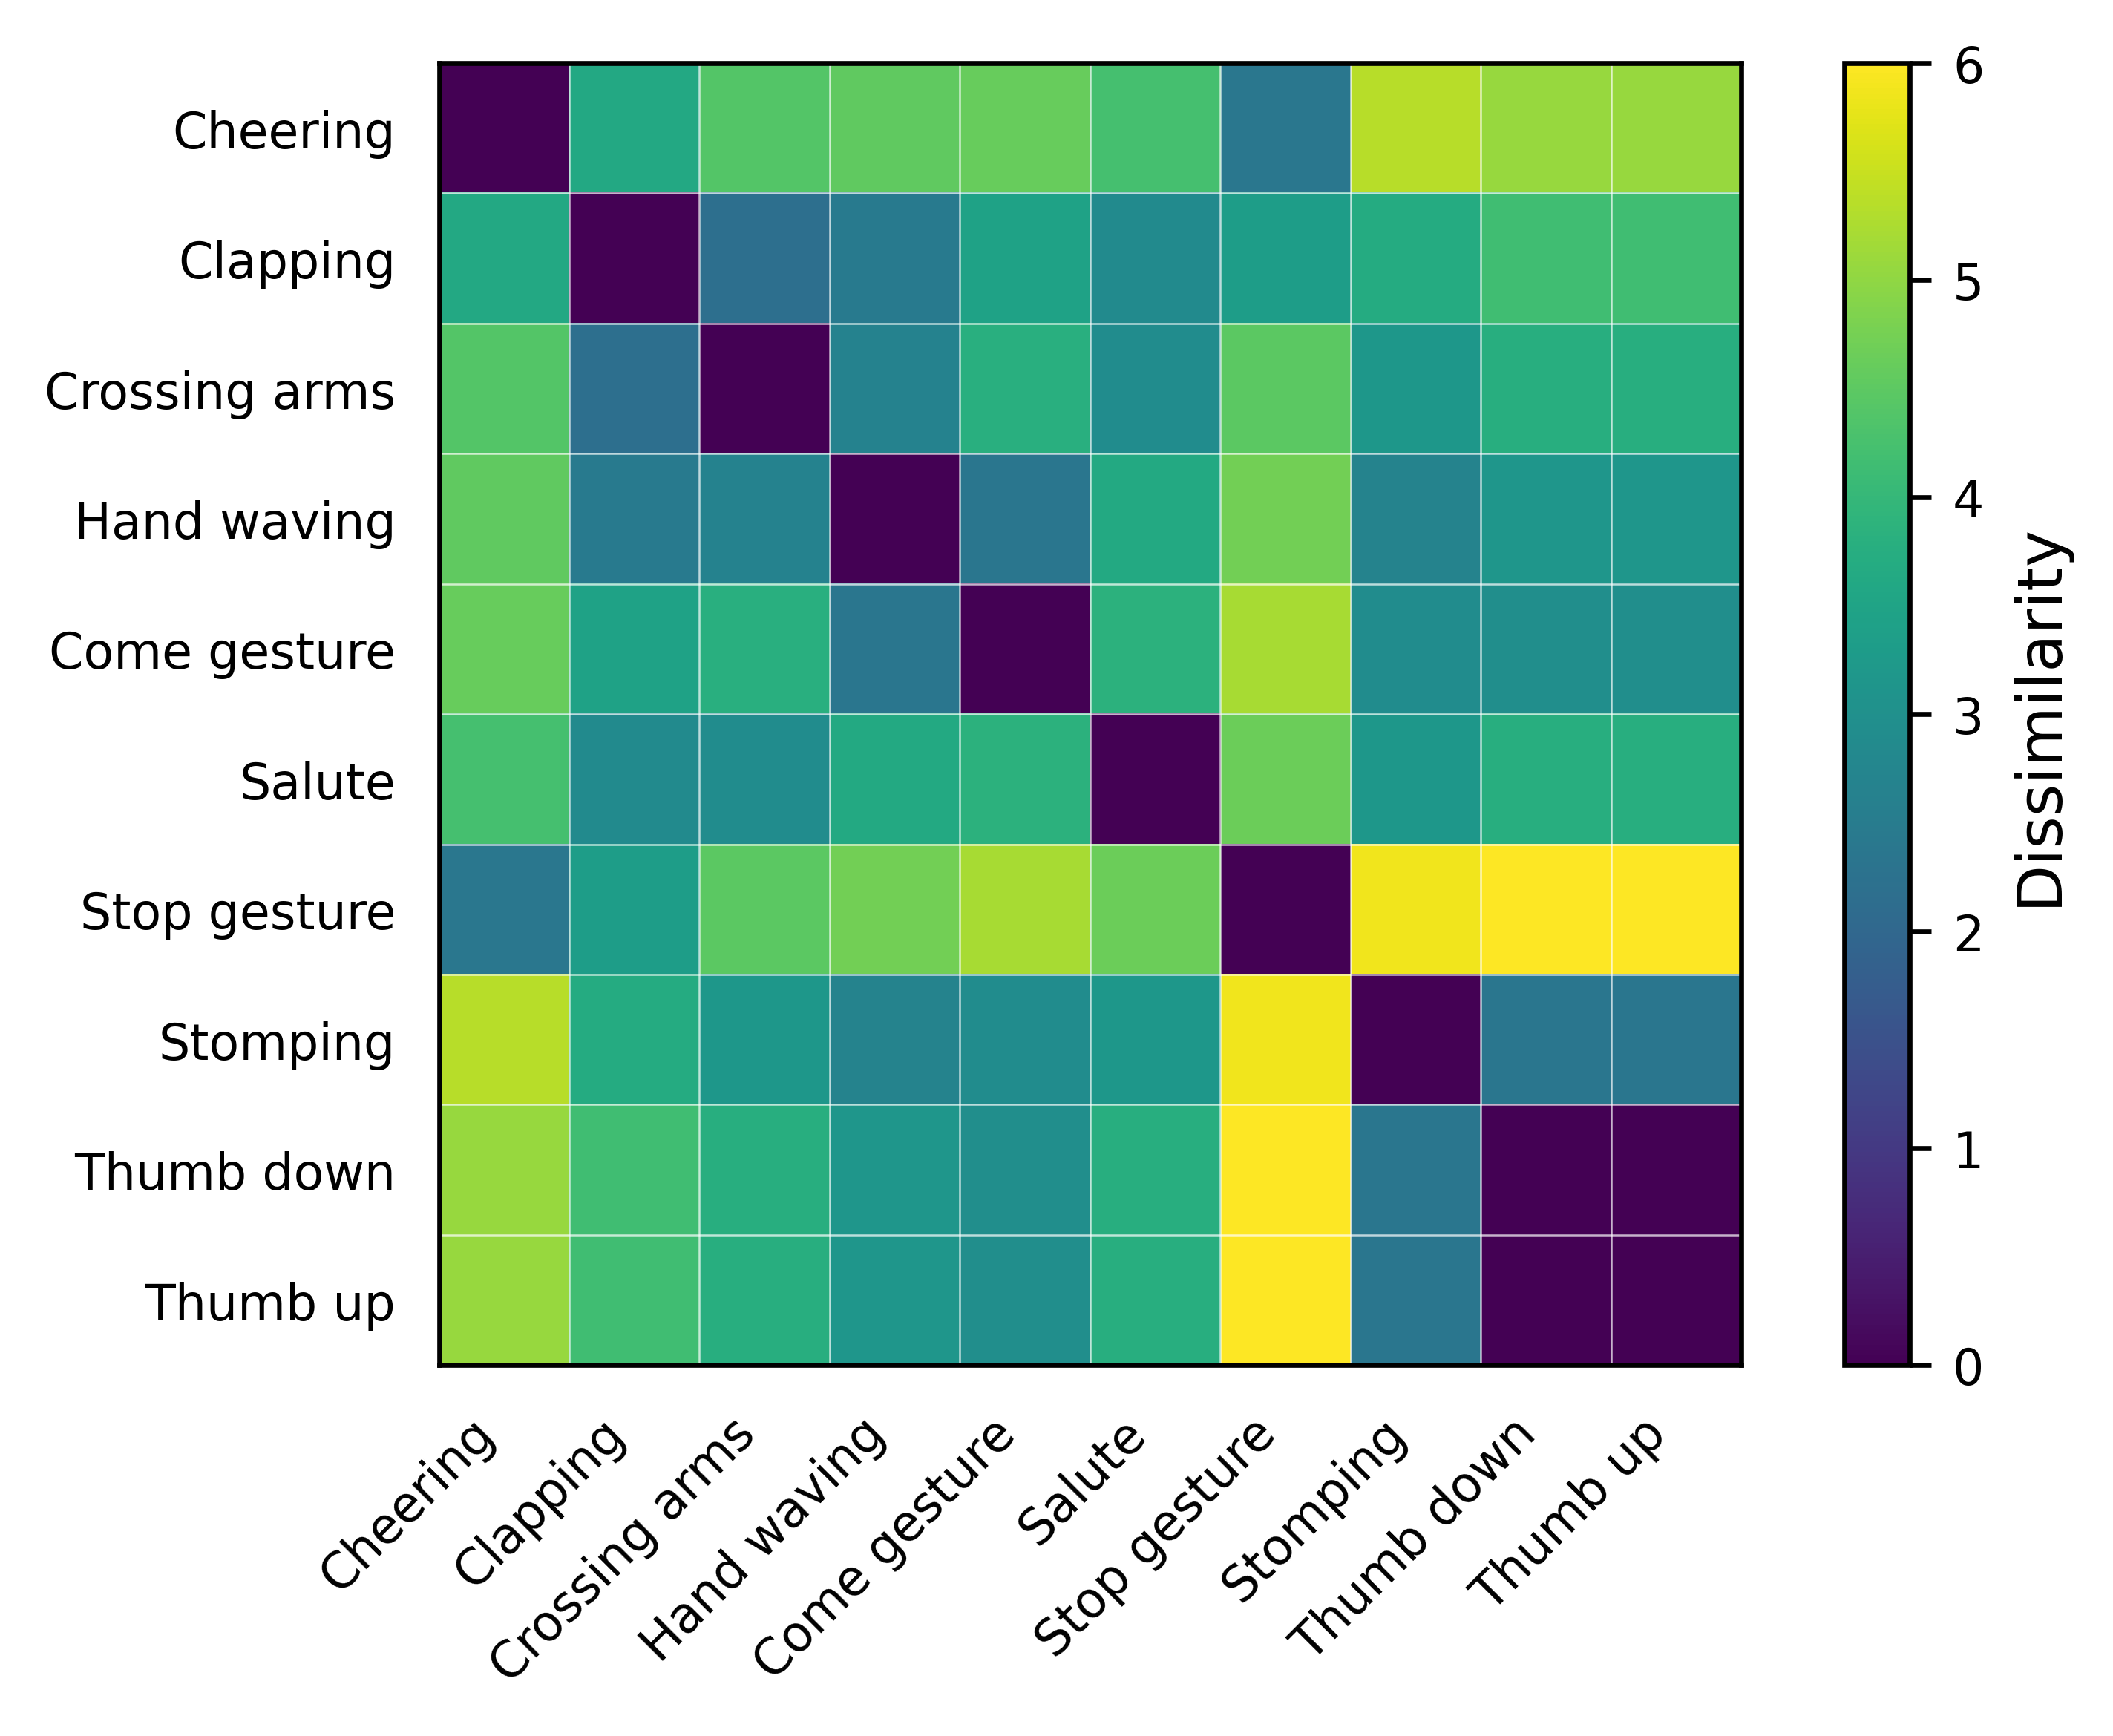

In [171]:
import numpy as np
import matplotlib.pyplot as plt

# Optionally, shorten labels a bit for readability
pretty_actions = [
    "Cheering",
    "Clapping",
    "Crossing arms",
    "Hand waving",
    "Come gesture",
    "Salute",
    "Stop gesture",
    "Stomping",
    "Thumb down",
    "Thumb up",
]

fig, ax = plt.subplots(figsize=(5, 4), dpi=600)

im = ax.imshow(RDM_motion_plot, interpolation="nearest", cmap="viridis")

# ticks & labels
ax.set_xticks(np.arange(n_actions))
ax.set_yticks(np.arange(n_actions))
ax.set_xticklabels(pretty_actions, rotation=45, ha="right", fontsize=8)
ax.set_yticklabels(pretty_actions, fontsize=8)

#ax.set_xlabel("Action", fontsize=10)
#ax.set_ylabel("Action", fontsize=10)
#ax.set_title("Movement RDM", fontsize=8, pad=10)

# colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.06)
cbar.set_label("Dissimilarity", fontsize=10)
cbar.ax.tick_params(labelsize=8)

# light grid to separate cells
ax.set_xticks(np.arange(-0.5, n_actions, 1), minor=True)
ax.set_yticks(np.arange(-0.5, n_actions, 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.3, alpha=0.7)

ax.tick_params(which="both", bottom=False, left=False)
ax.set_aspect("equal")

fig.tight_layout()
# high-res save for poster
fig.savefig("motion_RDM_poster.png", dpi=600, bbox_inches="tight")
plt.show()

In [111]:
# --------------------------------------------
# 3D MDS of movement RDM
# --------------------------------------------
mds_3d = MDS(
    n_components=3,
    dissimilarity='precomputed',
    random_state=1
)

coords_3d = mds_3d.fit_transform(RDM_motion)   # shape (10, 3)
print("3D MDS stress:", mds_3d.stress_)

3D MDS stress: 15.458091803201425


1D stress: 1014.6735774662156
2D stress: 74.29156927472093
3D stress: 15.458091803201425
4D stress: 4.619830974163794
5D stress: 2.665070545227864
6D stress: 1.623524758275402


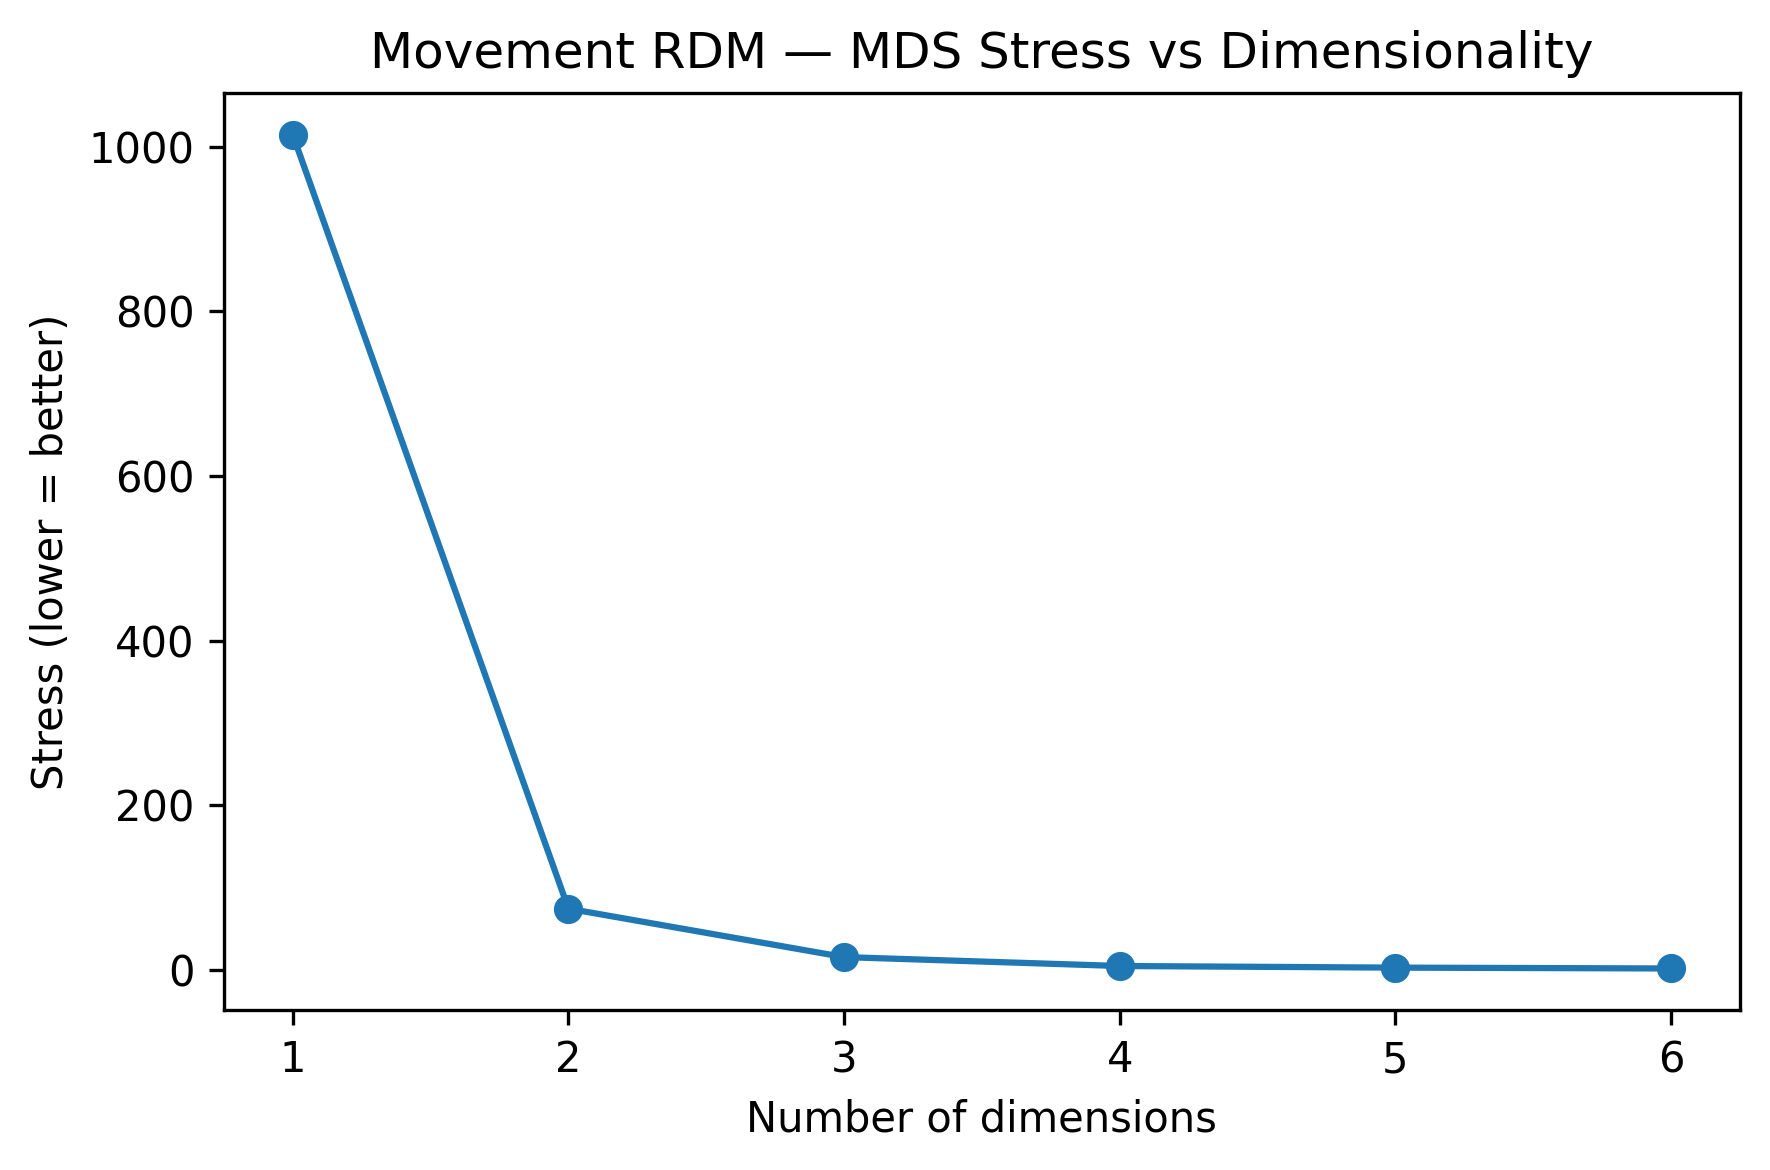

1D → 2D: 92.7% improvement
2D → 3D: 79.2% improvement
3D → 4D: 70.1% improvement
4D → 5D: 42.3% improvement
5D → 6D: 39.1% improvement


In [184]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# --------------------------------------------
# MDS stress analysis for the movement RDM
# --------------------------------------------

dims = range(1, 7)   # test 1D, 2D, ..., 6D
stresses = []

for d in dims:
    mds_d = MDS(
        n_components=d,
        dissimilarity="precomputed",
        random_state=1
    )
    mds_d.fit(RDM_motion)
    stresses.append(mds_d.stress_)
    print(f"{d}D stress: {mds_d.stress_}")

# --------------------------------------------
# Plot stress vs dimensionality
# --------------------------------------------
plt.figure(figsize=(6,4), dpi=300)
plt.plot(dims, stresses, marker="o", linewidth=1.5)
plt.xlabel("Number of dimensions")
plt.ylabel("Stress (lower = better)")
plt.title("Movement RDM — MDS Stress vs Dimensionality")
plt.xticks(dims)
plt.tight_layout()
plt.show()

# --------------------------------------------
# Relative improvement from (d-1) → d
# --------------------------------------------
for i in range(1, len(dims)):
    prev = stresses[i-1]
    curr = stresses[i]
    improvement = (prev - curr) / prev
    print(f"{dims[i-1]}D → {dims[i]}D: {improvement*100:.1f}% improvement")

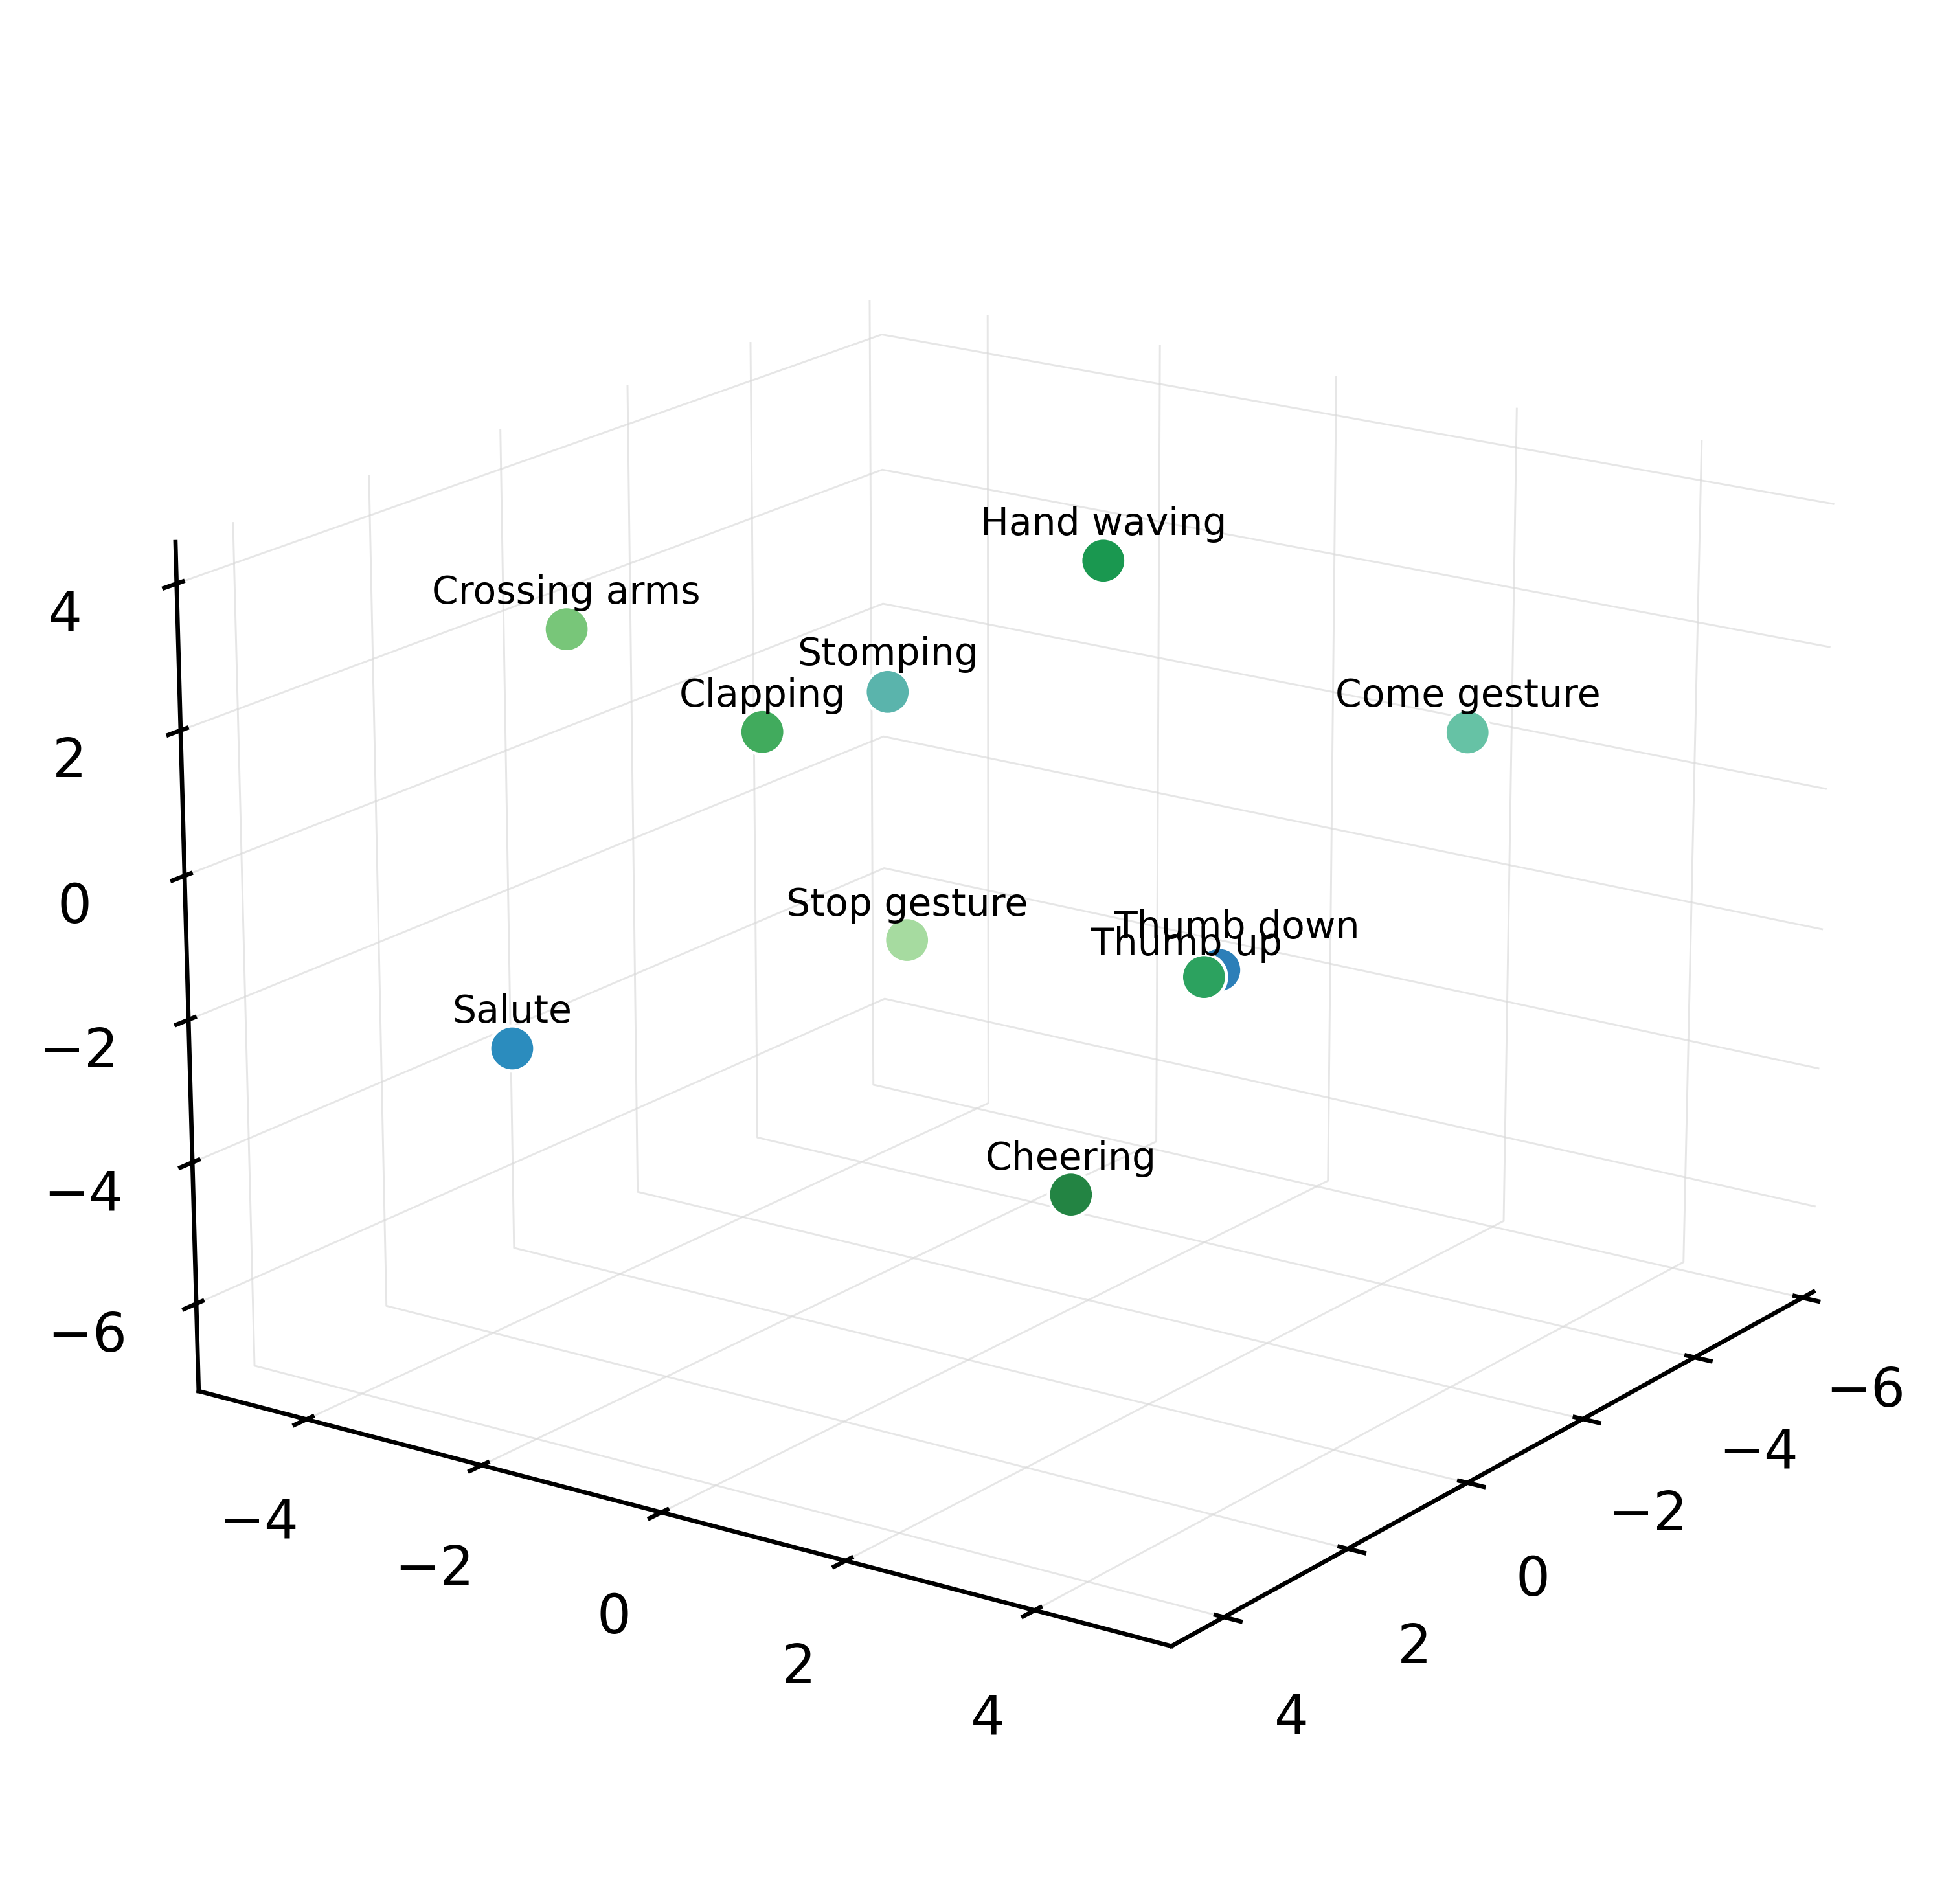

In [183]:
pretty_actions = [
    "Cheering",
    "Clapping",
    "Crossing arms",
    "Hand waving",
    "Come gesture",
    "Salute",
    "Stop gesture",
    "Stomping",
    "Thumb down",
    "Thumb up",
]

# --------- viridis-ish green/teal palette (no ultra-pale limes) ---------
green_teal_palette = [
    "#238443",  # Cheering      (deep green)
    "#41ab5d",  # Clapping
    "#78c679",  # Crossing arms
    "#1a9850",  # Hand waving
    "#66c2a5",  # Come gesture  (teal)
    "#2b8cbe",  # Salute        (blue-ish)
    "#a6dba0",  # Stop gesture
    "#5ab4ac",  # Stomping      (teal)
    "#2c7fb8",  # Thumb down    (blue)
    "#2ca25f",  # Strong green
]
colors = np.array(green_teal_palette)

# --------- tiny point nudges for thumbs (so circles themselves separate) ---------
coords_plot = coords_3d.copy()
coords_plot[8, 0] -= 0.12  # Thumb down slightly left
coords_plot[9, 0] += 0.12  # Thumb up slightly right

fig = plt.figure(figsize=(6, 5), dpi=600)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    coords_plot[:, 0],
    coords_plot[:, 1],
    coords_plot[:, 2],
    s=70,
    color=colors,
    edgecolor="white",
    linewidth=0.6,
    depthshade=False
)

# --------- label positions (separate Thumb up / Thumb down text) ---------
dz = 0.25  # lift all labels a bit

for i, label in enumerate(pretty_actions):
    # default: label right above the point
    lx = coords_plot[i, 0]
    ly = coords_plot[i, 1]
    lz = coords_plot[i, 2] + dz

    # custom tiny offsets only for the thumbs
    if label == "Thumb down":
        lx -= 0.20   # a little more left
        ly += 0.05
    elif label == "Thumb up":
        lx += 0.20   # a little more right
        ly -= 0.05

    ax.text(lx, ly, lz, label,
            fontsize=7, ha="center", va="bottom")

# axes + style
#ax.set_xlabel("Dim 1", fontsize=9)
#ax.set_ylabel("Dim 2", fontsize=9)
#ax.set_zlabel("Dim 3", fontsize=9)
#ax.set_title("Objective Movement Space — 3D MDS", fontsize=11, pad=10)

ax.view_init(elev=18, azim=35)

ax.xaxis.pane.set_alpha(0.0)
ax.yaxis.pane.set_alpha(0.0)
ax.zaxis.pane.set_alpha(0.0)

for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis._axinfo['grid']['linewidth'] = 0.35
    axis._axinfo['grid']['color'] = (0.85, 0.85, 0.85, 0.65)

margin = 0.9
ax.set_xlim(coords_plot[:,0].min()-margin, coords_plot[:,0].max()+margin)
ax.set_ylim(coords_plot[:,1].min()-margin, coords_plot[:,1].max()+margin)
ax.set_zlim(coords_plot[:,2].min()-margin, coords_plot[:,2].max()+margin)

fig.tight_layout()
fig.savefig("motion_MDS3D_poster.png", dpi=600, bbox_inches="tight")
plt.show()

In [113]:
stresses = {}

for d in range(1, 7):
    mds = MDS(n_components=d, dissimilarity='precomputed', random_state=1)
    mds.fit(RDM_motion)
    stresses[d] = mds.stress_

print("Stress by dimension:")
for d, s in stresses.items():
    print(d, "D:", s)

Stress by dimension:
1 D: 1014.6735774662156
2 D: 74.29156927472093
3 D: 15.458091803201425
4 D: 4.619830974163794
5 D: 2.665070545227864
6 D: 1.623524758275402


In [118]:
# Save
motion_data = {
    "actions": actions,
    "RDM_motion": RDM_motion,
    "coords_3d": coords_3d,
    "features": features,
    "stresses": stresses
}

OUT_FILE = "/Users/idilsu/Documents/Representations/Last/motion_RDM_and_MDS.pkl"
os.makedirs(os.path.dirname(OUT_FILE), exist_ok=True)

with open(OUT_FILE, "wb") as f:
    pickle.dump(motion_data, f)

print(f"\nSaved movement RDM and MDS to: {OUT_FILE}")


Saved movement RDM and MDS to: /Users/idilsu/Documents/Representations/Last/motion_RDM_and_MDS.pkl


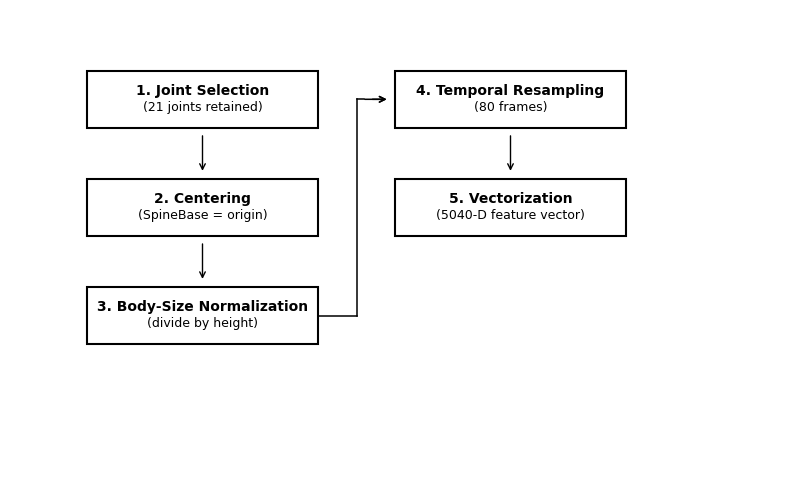

In [143]:

# Pipeline figure

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

# Box settings
box_width = 0.30
box_height = 0.12

# Column x-positions (with a small middle gap)
x_left = 0.10
x_right = 0.50

# Y positions (top → bottom)
ys = [0.75, 0.52, 0.29]

# Titles + subtitles (so we can bold only the titles)
left_titles = [
    "1. Joint Selection",
    "2. Centering",
    "3. Body-Size Normalization"
]
left_subs = [
    "(21 joints retained)",
    "(SpineBase = origin)",
    "(divide by height)"
]

right_titles = [
    "4. Temporal Resampling",
    "5. Vectorization"
]
right_subs = [
    "(80 frames)",
    "(5040-D feature vector)"
]

# ---------- DRAW LEFT COLUMN ----------
left_boxes = []
for title, sub, y in zip(left_titles, left_subs, ys):
    # box
    rect = Rectangle((x_left, y), box_width, box_height,
                     linewidth=1.5, edgecolor="black", facecolor="white")
    ax.add_patch(rect)

    # title (bold)
    ax.text(x_left + box_width/2, y + box_height*0.65, title,
            ha="center", va="center", fontsize=10, fontweight="bold")

    # subtitle (normal)
    ax.text(x_left + box_width/2, y + box_height*0.35, sub,
            ha="center", va="center", fontsize=9)

    left_boxes.append((x_left + box_width/2, y))

# ---------- DRAW RIGHT COLUMN ----------
right_boxes = []
for title, sub, y in zip(right_titles, right_subs, ys[:2]):
    rect = Rectangle((x_right, y), box_width, box_height,
                     linewidth=1.5, edgecolor="black", facecolor="white")
    ax.add_patch(rect)

    ax.text(x_right + box_width/2, y + box_height*0.65, title,
            ha="center", va="center", fontsize=10, fontweight="bold")
    ax.text(x_right + box_width/2, y + box_height*0.35, sub,
            ha="center", va="center", fontsize=9)

    right_boxes.append((x_right + box_width/2, y))

# ---------- VERTICAL ARROWS INSIDE COLUMNS ----------
for boxes in [left_boxes, right_boxes]:
    for i in range(len(boxes)-1):
        x = boxes[i][0]
        y_top = boxes[i][1]
        y_bottom = boxes[i+1][1] + box_height
        ax.annotate("",
                    xy=(x, y_bottom),
                    xytext=(x, y_top),
                    arrowprops=dict(arrowstyle="->",
                                    linewidth=1.0,
                                    shrinkA=6, shrinkB=6))


# ---------- CLEAN CONNECTOR: Step 3 (left) → Step 4 (right) ----------

# start: right middle of box 3
x3_right = x_left + box_width
y3_mid = ys[2] + box_height/2

# end: left middle of box 4
x4_left = x_right
y4_mid = ys[0] + box_height/2

# intermediate x in the middle of the gap
x_mid = (x3_right + x4_left) / 2

# 1) horizontal from box 3 to the middle of the gap
ax.plot([x3_right, x_mid], [y3_mid, y3_mid],
        color="black", linewidth=1.1)

# 2) vertical up from 3's height to 4's height
ax.plot([x_mid, x_mid], [y3_mid, y4_mid],
        color="black", linewidth=1.1)

# 3) horizontal with arrowhead into box 4
ax.annotate("",
            xy=(x4_left, y4_mid),
            xytext=(x_mid, y4_mid),
            arrowprops=dict(arrowstyle="->",
                            linewidth=1.1,
                            shrinkA=6, shrinkB=6))

# extend the line slightly past x_mid
x_arrow_start = x_mid + 0.01   # tiny offset to avoid gap

ax.plot([x_mid, x_arrow_start], [y4_mid, y4_mid],
        color="black", linewidth=1.1)

# arrow to box 4
ax.annotate("",
            xy=(x4_left, y4_mid),
            xytext=(x_arrow_start, y4_mid),
            arrowprops=dict(arrowstyle="->",
                            linewidth=1.1,
                            shrinkA=6, shrinkB=6))

# ---------- TITLE ----------
#ax.text(0.5, 0.92, "Motion Data Processing Pipeline",
#       ha="center", va="center", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

# Optional save:
fig.savefig("motion_pipeline_two_column_final.png", dpi=600, bbox_inches="tight")